# Part II. Simple CNN plus land mask and season

**Author:** Eli Holmes (NOAA), Yifei Hang (UW Varanasi intern 2024), Jiarui Yu (UW Varanasi intern 2023)

[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/nmfs-opensci/nmfshackdays-2025/blob/main/topics-2025/2025-02-14-earthdata/2-subset-and-plot.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link]

[download-link]: https://nmfs-opensci.github.io/NMFSHackDays-2025/topics-2025/2025-02-14-earthdata/2-subset-and-plot.ipynb
[colab-link]: https://colab.research.google.com/github/nmfs-opensci/nmfshackdays-2025/blob/main/topics-2025/2025-02-14-earthdata/2-subset-and-plot.ipynb
[jupyter-link]: https://nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/nmfs-opensci/nmfshackdays-2025/main/topics-2025/2025-02-14-earthdata/2-subset-and-plot.ipynb

We added the land/ocean mask as an input so the model can learn the land and tell the model not to train on the y (CHL) that is over land since those are not real data. Now let's also add season.

Our new model has spatial variables, seasonal variables, and an ocean mask (categorical).

| Feature        | Spatial Variation       | Temporal Variation | Notes                             |
|----------------|-------------------------|--------------------|-----------------------------------|
| `sst`          | ✅ Varies by lat/lon     | ✅ Varies by time   | Numeric, normalize                |
| `so`           | ✅ Varies by lat/lon     | ✅ Varies by time   | Numeric, normalize                |
| `sin_time`     | ❌ Same across lat/lon   | ✅ Varies by time   | Cyclical, **do not normalize**    |
| `cos_time`     | ❌ Same across lat/lon   | ✅ Varies by time   | Cyclical, **do not normalize**    |
| `ocean_mask`   | ✅ Varies by lat/lon     | ❌ Static           | Binary (0=land, 1=ocean), do not normalize |
| `y` (response) | ✅ Varies by lat/lon     | ✅ Varies by time   | Numeric, maybe normalize  |

### How the CNN Uses These

- **`sst` and `so`**: These are our core spatial-temporal features. The CNN will learn spatial filters to extract patterns over ocean and time.
  
- **`sin_time` and `cos_time`**: These introduce seasonality into our model. The CNN can learn seasonally dependent patterns, e.g., chlorophyll blooms in spring. The `sin_time` and `cos_time` features are designed to represent **seasonality** using a **cyclical encoding**. Normalizing these features (e.g., to mean 0, std 1) would **distort their circular geometry** and defeat their intended purpose.

- **`ocean_mask`**: This acts like a location-aware binary filter. It tells the CNN which pixels are land (0) vs ocean (1), which helps avoid learning patterns over invalid/land areas.

- **`y` (response)**: The model trains on this. We have logged it and it is roughly centered near 0. We need to evaluate whether our response has areas with much much higher variance than other areas. If so, we need to do some spatial normalization so our model doesn't only learn the high variance areas.


## Shutdown kernels!

Kernel > Shutdown All Kernels

Make sure to reset things so we don't run out of memory.

## Load the libraries

In [1]:
# --- Core data handling libraries ---
import xarray as xr       # for working with labeled multi-dimensional arrays
import numpy as np        # for numerical operations on arrays
import dask.array as da   # for lazy, parallel array operations (used in xarray backends)

# --- Plotting ---
import matplotlib.pyplot as plt  # for creating plots

# --- TensorFlow setup ---
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # suppress TensorFlow log spam (0=all, 3=only errors)

import tensorflow as tf  # main deep learning framework

# --- Keras (part of TensorFlow): building and training neural networks ---
from keras.models import Sequential          # lets us stack layers in a simple linear model
from keras.layers import Conv2D              # 2D convolution layer — finds spatial patterns in image-like data
from keras.layers import BatchNormalization  # stabilizes and speeds up training by normalizing activations
from keras.layers import Dropout             # randomly "drops" neurons during training to reduce overfitting
from keras.callbacks import EarlyStopping    # stops training early if validation loss doesn't improve

2025-06-12 03:36:56.089632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-12 03:36:56.108229: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-12 03:36:56.113762: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## See what machine we are on

In [34]:
# list all the physical devices
physical_devices = tf.config.list_physical_devices()
print("All Physical Devices:", physical_devices)

# list all the available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Print infomation for available GPU if there exists any
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print("GPU Details:", details)
else:
    print("No GPU available")

All Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Details: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


## Load data

I created the data for Part I in `Data_Prep_Part_2`. Here I will load.

- sst, so, sin_time, cos_time
- ocean_mask
- y (CHL)

In [2]:
# read in the Zarr file; a 3D (time, lat, lon) cube for a bunch of variables in the Indian Ocean
dataset = xr.open_zarr("~/shared-readwrite/cnn/part2.zarr")

## Check the response variable

The model is going to learn the high variance areas more also the high mean areas will have higher errors (because higher mean) and will factor more in the model loss. So predictions should be better in the yellow areas and worse in the dark blue. That is maybe not too bad for our purpose.

Given these plots, I will not spatially normalize y (log chlorophyll).

In [38]:
y = dataset['y']  # shape: (time, lat, lon)

# Mean and std across time for each (lat, lon)
y_mean_map = y.mean(dim='time')
y_std_map = y.std(dim='time')

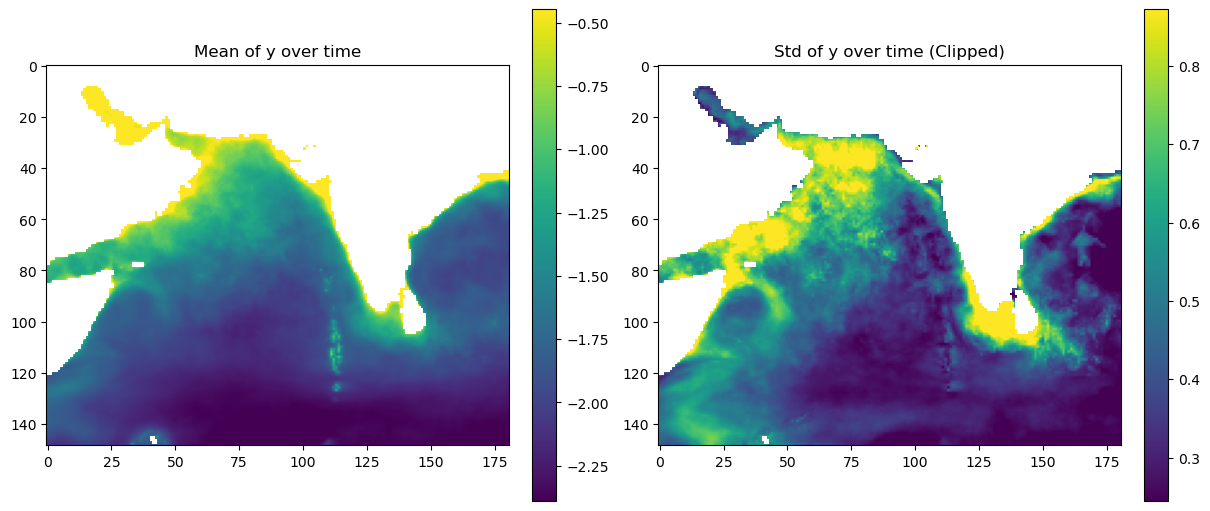

In [39]:
vmin_std = np.nanpercentile(y_std_map, 5)
vmax_std = np.nanpercentile(y_std_map, 95)
vmin_mean = np.nanpercentile(y_mean_map, 5)
vmax_mean = np.nanpercentile(y_mean_map, 95)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Mean
im0 = axs[0].imshow(y_mean_map, origin='upper', cmap='viridis',
                    vmin=vmin_mean, vmax=vmax_mean)
axs[0].set_title('Mean of y over time')
plt.colorbar(im0, ax=axs[0])

# Std
im1 = axs[1].imshow(y_std_map, origin='upper', cmap='viridis',
                    vmin=vmin_std, vmax=vmax_std)
axs[1].set_title('Std of y over time (Clipped)')
plt.colorbar(im1, ax=axs[1])

plt.show()


## Process the data

Normalize the `num_var`, don't normalize `cat_var`, replace NaN with 0. Split data randomly.

In [3]:
import numpy as np
import dask.array as da

def time_series_split(data, num_var, cat_var, split_ratio=(0.7, 0.2, 0.1), seed=42):
    """
    Splits time indices randomly (without replacement) into train/val/test, but preserves order within each split.
    Replaces NaNs with 0s and normalizes numerical variables.

    Parameters:
        data: xarray dataset with 'time' dimension
        num_var: list of numerical variable names
        cat_var: list of categorical variable names
        split_ratio: tuple (train, val, test), must sum to 1.0
        seed: random seed

    Returns:
        X, y, X_train, y_train, X_val, y_val, X_test, y_test
    """
    time_dim = "time"
    if time_dim not in data.dims:
        raise ValueError("Dataset must contain a 'time' dimension.")
    
    time_len = data.sizes[time_dim]
    rng = np.random.default_rng(seed)
    all_indices = rng.choice(time_len, size=time_len, replace=False)

    # Compute split indices
    train_end = int(split_ratio[0] * time_len)
    val_end = int((split_ratio[0] + split_ratio[1]) * time_len)
    train_idx = np.sort(all_indices[:train_end])
    val_idx = np.sort(all_indices[train_end:val_end])
    test_idx = np.sort(all_indices[val_end:])

    pred_arrays = []

    # Process numerical variables
    for var in num_var:
        arr = data[var]
        if time_dim not in arr.dims:
            arr = arr.expand_dims({time_dim: data["time"]})
            arr = arr.broadcast_like(data["sst"])
        arr = arr.transpose(time_dim, ...)  # (time, lat, lon)
        arr_data = da.nan_to_num(arr.data)
        mean = arr_data.mean()
        std = arr_data.std()
        arr_data = (arr_data - mean) / (std + 1e-8)
        pred_arrays.append(arr_data)

    # Process categorical variables
    for var in cat_var:
        arr = data[var]
        if time_dim not in arr.dims:
            arr = arr.expand_dims({time_dim: data["time"]})
            arr = arr.broadcast_like(data["sst"])
        arr = arr.transpose(time_dim, ...)
        arr_data = da.nan_to_num(arr.data)
        pred_arrays.append(arr_data)

    X = da.stack(pred_arrays, axis=-1)  # (time, lat, lon, features)
    y = da.nan_to_num(data["y"].transpose(time_dim, ...).data)

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    return X, y, X_train, y_train, X_val, y_val, X_test, y_test


Here we create our training and test data with 2 variables using only 2020. 70% data for training, 20% for validation and 10% for testing.

In [4]:
num_var = ['sst', 'so'] 
cat_var = ['ocean_mask', 'sin_time', 'cos_time']
split_ratio = [.7, .2, .1]
X, y, X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(dataset, num_var, cat_var, split_ratio)

## Create the CNN model

In [10]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, BatchNormalization, Dropout

def create_model_CNN(input_shape):
    """
    Create a simple 3-layer CNN model for gridded ocean data.

    Parameters
    ----------
    input_shape : tuple
        The shape of each sample, e.g., (149, 181, 2)

    Returns
    -------
    model : keras.Model
        CNN model to predict CHL from SST and salinity
    """
    model = Sequential()

    # Input layer defines the input dimensions for the CNN
    model.add(Input(shape=input_shape))

    # Layer 1 — learns fine-scale 3x3 spatial features
    # Let the model learn 64 different patterns (filters) in the data at this layer.
    # activation relu is non-linearity
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Layer 2 — expands context to 5x5; combines fine features into larger structures
    # Reduce the number of patterns (filters) so we gradually reduce model complexity
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Layer 3 — has access to ~7x7 neighborhood; outputs CHL prediction per pixel
    # Combines all the previous layer’s features into a CHL estimate at each pixel
    # 1 response (chl) — hence, 1 prediction pixel = filter
    # linear since predicting a real continuous variable (log CHL)
    model.add(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='linear'))

    return model

## Create a custom loss function so don't train on land

In [11]:
# Load ocean mask from dataset and convert to numpy
# Assumes ocean_mask is (lat, lon)
ocean_mask = dataset['ocean_mask'].values.astype(np.float32)

import tensorflow as tf

# Convert once and reuse — do *not* redefine inside the loss function!
ocean_mask_tf = tf.convert_to_tensor(ocean_mask)[tf.newaxis, ..., tf.newaxis]  # shape (1, lat, lon, 1)

def masked_mae(y_true, y_pred):
    if y_true.shape.rank == 3:
        y_true = tf.expand_dims(y_true, axis=-1)
    if y_pred.shape.rank == 3:
        y_pred = tf.expand_dims(y_pred, axis=-1)

    masked_diff = tf.abs(y_true - y_pred) * ocean_mask_tf
    return tf.reduce_sum(masked_diff) / tf.reduce_sum(ocean_mask_tf)

### Let's build the model

We build a simple 3-layer CNN model. Each layer preserves the (lat, lon) shape and learns filters to extract spatial patterns. The model has ~20,000 trainable parameters, which we can see from `model.summary()`. This is small compared to huge modern CNNs (millions of parameters).

In [12]:
# Get shape of one input sample: (lat, lon, n_features)
input_shape = X_train.shape[1:]

# Create the model using the correct input shape
model = create_model_CNN(input_shape)

# Check the model summary
# model.summary()

## Let's train the model

In [14]:
# Compile the model with Adam optimizer and mean absolute error (MAE) as both loss and evaluation metric
model.compile(
    optimizer='adam',    # Efficient and widely used optimizer
    loss=masked_mae,          # Mean Absolute Error: good for continuous data like CHL
    metrics=[masked_mae]      # Also track MAE during training/validation
)
model.compile(optimizer='adam',  loss='mae', metrics=['mae'])

# Set up early stopping to prevent overfitting
early_stop = EarlyStopping(
    patience=10,              # Stop if validation loss doesn't improve for 10 epochs
    restore_best_weights=True  # Revert to the model weights from the best epoch
)

# Create a TensorFlow dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024)  # Shuffle the data (helps generalization)
train_dataset = train_dataset.batch(8)                   # Batch size = 8

# Create a TensorFlow dataset for validation (no shuffle)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(8)

# Train the model
history = model.fit(
    train_dataset,
    epochs=50,                    # Maximum number of training epochs
    validation_data=val_dataset, # Use validation data during training
    callbacks=[early_stop]       # Stop early if no improvement
)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 8.5367 - masked_mae: 8.5367 - val_loss: 9.4772 - val_masked_mae: 9.4772
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.2874 - masked_mae: 5.2874 - val_loss: 8.8132 - val_masked_mae: 8.8132
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.7909 - masked_mae: 4.7909 - val_loss: 7.8259 - val_masked_mae: 7.8259
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.3763 - masked_mae: 4.3763 - val_loss: 6.9263 - val_masked_mae: 6.9263
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.0398 - masked_mae: 4.0398 - val_loss: 6.7421 - val_masked_mae: 6.7421
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.8447 - masked_mae: 3.8447 - val_loss: 6.1692 - val_masked_mae: 6.1692
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.7683 - masked_mae: 3.7683 - val_loss: 5.3608 - val_masked_mae: 5.3608
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.6307 - masked_mae: 3.6

## Plot training & validation loss values

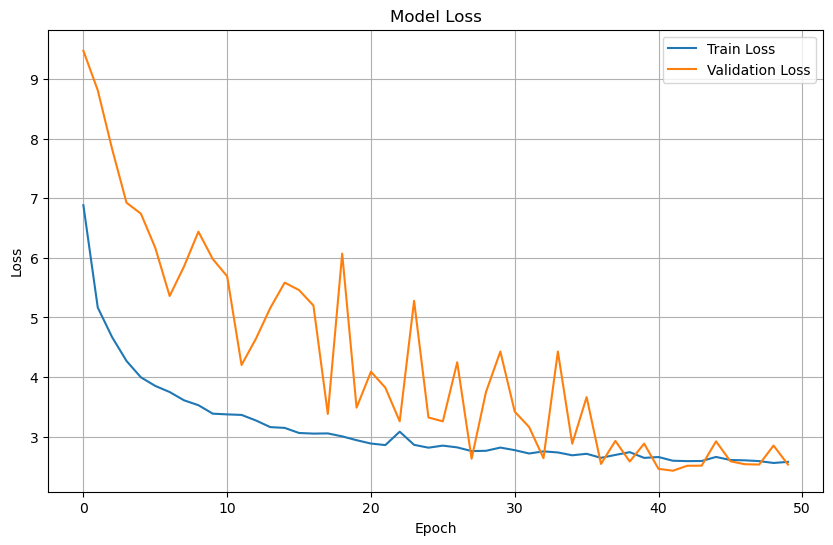

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Prepare test dataset

In [48]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(4)

# Evaluate the model on the test dataset
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.0827 - masked_mae: 1.0716
Test Loss: 1.0319781303405762
Test MAE: 0.9657359719276428


## Make some maps of our predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


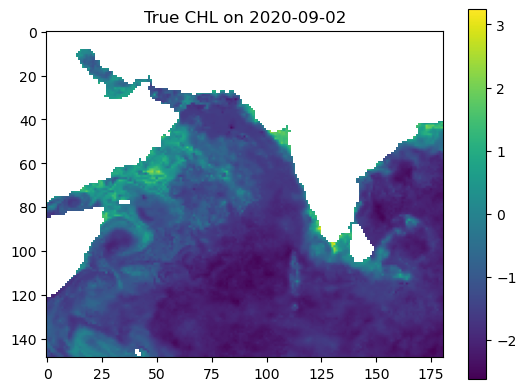

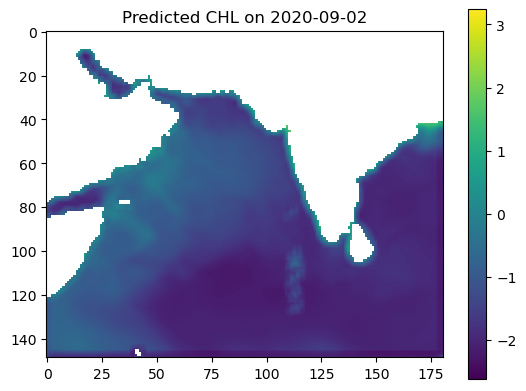

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Example: date to predict
date_to_predict = np.datetime64("2020-09-02")

# Get index of that date
available_times = dataset["time"].values
date_index = np.where(available_times == date_to_predict)[0][0]

# Prepare input (X: shape = [time, lat, lon, n_features])
input_data = X[date_index]  # shape = (lat, lon, n_features)
input_data = np.array(input_data)     # convert to numpy

# Predict
predicted_output = model.predict(input_data[np.newaxis, ...])[0]
predicted_output = predicted_output[:, :, 0]  # shape = (lat, lon)

# True value from y
true_output = y[date_index]

# Mask land (land_mask = ~ocean)
land_mask = dataset["ocean_mask"].values == 0.0
predicted_output[land_mask] = np.nan
true_output = np.where(land_mask, np.nan, true_output)

# Plot
vmin = np.nanmin([true_output, predicted_output])
vmax = np.nanmax([true_output, predicted_output])

plt.imshow(true_output, vmin=vmin, vmax=vmax, cmap='viridis')
plt.colorbar()
plt.title(f"True CHL on {date_to_predict}")
plt.show()

plt.imshow(predicted_output, vmin=vmin, vmax=vmax, cmap='viridis')
plt.colorbar()
plt.title(f"Predicted CHL on {date_to_predict}")
plt.show()


### Let's look at all the months

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


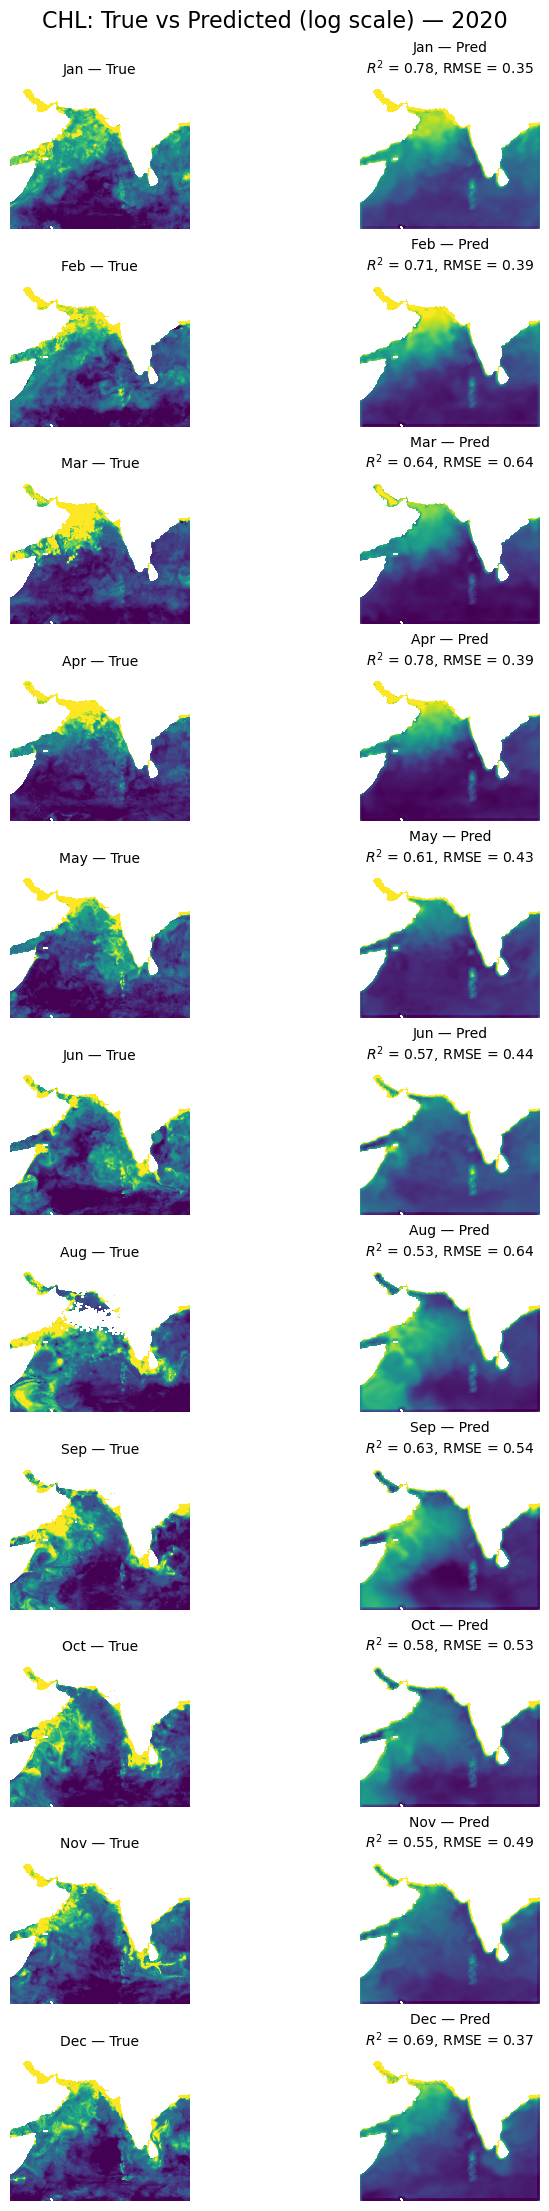

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# Get available time points and group by month
available_dates = pd.to_datetime(dataset.time.values)
monthly_dates = (
    pd.Series(available_dates)
    .groupby([available_dates.year, available_dates.month])
    .min()
    .sort_values()
)
n_months = len(monthly_dates)

# lat/lon info
lat = dataset.lat.values
lon = dataset.lon.values
extent = [lon.min(), lon.max(), lat.min(), lat.max()]
flip_lat = lat[0] > lat[-1]
land_mask = dataset["ocean_mask"].values == 0.0

# Create figure and axes
fig, axs = plt.subplots(n_months, 2, figsize=(7, 2 * n_months), constrained_layout=True)

for i, date in enumerate(monthly_dates):
    # Get time index
    date_index = np.where(available_dates == date)[0][0]

    # True output
    true_output = dataset['y'].sel(time=date).values
    if flip_lat:
        true_output = np.flipud(true_output)

    # Prediction
    input_data = np.array(X[date_index])
    predicted_output = model.predict(input_data[np.newaxis, ...])[0]
    predicted_output = predicted_output[:, :, 0]  # shape = (lat, lon)
    
    # Mask land (land_mask = ~ocean)
    predicted_output[land_mask] = np.nan

    if flip_lat:
        predicted_output = np.flipud(predicted_output)

    # Shared color scale
    vmin = np.nanpercentile([true_output, predicted_output], 5)
    vmax = np.nanpercentile([true_output, predicted_output], 95)

    # Compute R² (flatten and mask NaNs)
    true_flat = true_output.flatten()
    pred_flat = predicted_output.flatten()
    valid_mask = ~np.isnan(true_flat) & ~np.isnan(pred_flat)
    r2 = r2_score(true_flat[valid_mask], pred_flat[valid_mask])
    rmse = np.sqrt(np.mean((true_flat[valid_mask] - pred_flat[valid_mask]) ** 2))

    # Plot true
    axs[i, 0].imshow(true_output, origin='lower', extent=extent,
                     vmin=vmin, vmax=vmax, cmap='viridis',
                     aspect='equal')
    axs[i, 0].set_title(f"{date.strftime('%b')} — True", fontsize=10)
    axs[i, 0].axis('off')

    # Plot predicted with R²
    axs[i, 1].imshow(predicted_output, origin='lower', extent=extent,
                     vmin=vmin, vmax=vmax, cmap='viridis', 
                     aspect='equal')
    axs[i, 1].set_title(f"{date.strftime('%b')} — Pred\n$R^2$ = {r2:.2f}, RMSE = {rmse:.2f}", fontsize=10)
    axs[i, 1].axis('off')

plt.suptitle('CHL: True vs Predicted (log scale) — 2020', fontsize=16)
plt.show()


## Summary

Now we have a model that is doing ok. It still doesn't pick up the upwelling zone at the southern tip of India. There is something about that area that is different and that the model is unable to learn. We should look into what drives that upwelling zone. It maybe that the relationship between SST and salinity are different there. It pokes down into a strong E-W current system.